[*********************100%***********************]  2 of 2 completed


Average Rolling Correlation (60-day): 0.92
Hedge Ratio (OLS): 0.2249

ADF Test on Full Sample Spread
ADF Statistic: -2.3186
p-value: 0.1660
Critical Values:
   1%: -3.4435
   5%: -2.8673
   10%: -2.5699

Spread stationary (p < 0.05) in 2.00% of rolling windows


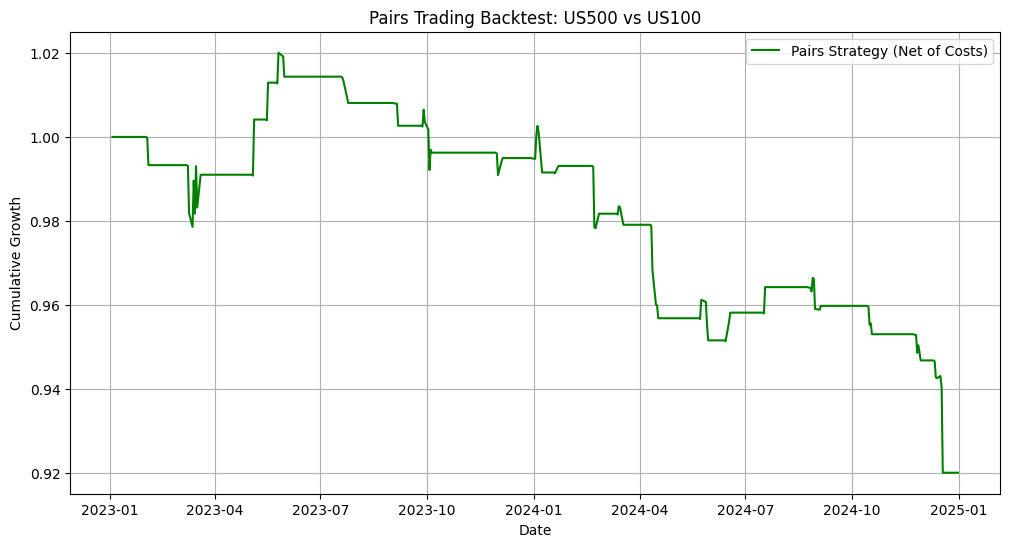


Final Return (Net of Costs): -8.00%
Annualized Sharpe Ratio: -1.15


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# --------------------------------------------------
# 1. Setup (US Indices)
# --------------------------------------------------
stock_y = '^GSPC'   # US500 (S&P 500)
stock_x = '^NDX'    # US100 (Nasdaq-100)
tickers = [stock_y, stock_x]

# --------------------------------------------------
# 2. Data Collection
# --------------------------------------------------
data = yf.download(
    tickers,
    start="2023-01-01",
    end="2025-01-01",
    auto_adjust=True
)

prices = data['Close'].dropna()

# --------------------------------------------------
# 3. Correlation Check (Pair Selection)
# --------------------------------------------------
rolling_corr = prices[stock_y].rolling(60).corr(prices[stock_x])
avg_corr = rolling_corr.mean()

print(f"Average Rolling Correlation (60-day): {avg_corr:.2f}")

# --------------------------------------------------
# 4. Hedge Ratio (OLS)
# --------------------------------------------------
Y = prices[stock_y]
X = sm.add_constant(prices[stock_x])

model = sm.OLS(Y, X).fit()
hedge_ratio = model.params[stock_x]

print(f"Hedge Ratio (OLS): {hedge_ratio:.4f}")

# --------------------------------------------------
# 5. Spread & Z-Score
# --------------------------------------------------
data['spread'] = prices[stock_y] - hedge_ratio * prices[stock_x]

window = 20
data['zscore'] = (
    (data['spread'] - data['spread'].rolling(window).mean())
    / data['spread'].rolling(window).std()
)

# --------------------------------------------------
# 6. Global Cointegration Check (ADF)
# --------------------------------------------------
adf_result = adfuller(data['spread'].dropna())

print("\nADF Test on Full Sample Spread")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for k, v in adf_result[4].items():
    print(f"   {k}: {v:.4f}")

# --------------------------------------------------
# 7. Rolling ADF (Local Stationarity)
# --------------------------------------------------
rolling_window = 252  # ~1 trading year
spread_series = data['spread'].dropna()

rolling_pvals = []

for i in range(rolling_window, len(spread_series)):
    sub_series = spread_series.iloc[i-rolling_window:i]
    pval = adfuller(sub_series)[1]
    rolling_pvals.append(pval)

rolling_pvals = pd.Series(
    rolling_pvals,
    index=spread_series.index[rolling_window:]
)

stationary_pct = (rolling_pvals < 0.05).mean() * 100
print(f"\nSpread stationary (p < 0.05) in {stationary_pct:.2f}% of rolling windows")

# --------------------------------------------------
# 8. Trading Signals
# --------------------------------------------------
data['position'] = 0
data.loc[data['zscore'] > 2, 'position'] = -1   # Sell spread
data.loc[data['zscore'] < -2, 'position'] = 1   # Buy spread
data['position'] = data['position'].ffill().fillna(0)

# --------------------------------------------------
# 9. Strategy Returns
# --------------------------------------------------
data['returns'] = (
    data['position'].shift(1)
    * (
        prices[stock_y].pct_change()
        - hedge_ratio * prices[stock_x].pct_change()
    )
)

# --------------------------------------------------
# 10. Transaction Costs (US Index Products ~0.02%)
# --------------------------------------------------
transaction_cost = 0.0002
data['trades'] = data['position'].diff().abs()
data['net_returns'] = data['returns'] - transaction_cost * data['trades']

data['cumulative_returns'] = (1 + data['net_returns'].fillna(0)).cumprod()

# --------------------------------------------------
# 11. Plot Results
# --------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(
    data['cumulative_returns'],
    label='Pairs Strategy (Net of Costs)',
    color='green'
)
plt.title(f'Pairs Trading Backtest: US500 vs US100')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------
# 12. Final Metrics
# --------------------------------------------------
final_return = (data['cumulative_returns'].iloc[-1] - 1) * 100
sharpe = (
    data['net_returns'].mean()
    / data['net_returns'].std()
) * np.sqrt(252)

print(f"\nFinal Return (Net of Costs): {final_return:.2f}%")
print(f"Annualized Sharpe Ratio: {sharpe:.2f}")
